In [1]:
from python_folder.utils import *
from python_folder.model_cvae import *
from python_folder.train_cvae import *

/Users/Aurel/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/drawSvg/raster.py:18: RuntimeWarning: Failed to import CairoSVG. drawSvg will be unable to output PNG or other raster image formats. See https://github.com/cduck/drawSvg#prerequisites for more details.
Original OSError: no library called "cairo-2" was found
no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': dlopen(libcairo.so.2, 0x0002): tried: '/Users/Aurel/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/../../libcairo.so.2' (no such file), '/Users/Aurel/opt/anaconda3/envs/myenv/bin/../lib/libcairo.so.2' (no such file), 'libcairo.so.2' (no such file), '/usr/local/lib/libcairo.so.2' (no such file), '/usr/lib/libcairo.so.2' (no such file), '/Users/Aurel/Documents/PFE/CODE/SVG/Clean_Folder/libcairo.so.2' (no such file), '/usr/local/lib/libcairo.so.2' (no such file), '/usr/lib/libcairo.so.2' (no such file)
cannot load library 'libcairo.2.dylib': dlopen(libc

# First we create our dataset of smileys under the condition : 
- if y = 0 : it is a sad smiley, 
- if y = 1 : it is a happy smiley 

In [5]:
length = 7000  # the length of the data set
tensor_data = []

for i in range(length):    
    y = randint(0, 1)  # the label
    x = torch.from_numpy(generate_matrix_cond(y)) # convert array into tensor
    list = (x, y)
    tensor_data.append(list)

In [6]:
# Splitting the set :
train_set, val_set, test_set = torch.utils.data.random_split(tensor_data, [5000, 1000, 1000])
print(len(train_set))
print(len(val_set))
print(len(test_set))

5000
1000
1000


In [7]:
# Dataloader : 

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size = 10, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(test_set, batch_size = 10, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size = 10, shuffle = True)

# Now we run the training: 

In [60]:
### Dimension of the latent space: 
latent_dims = 2

### Our cVAE: 
cVAE = Cond_Variational_Autoencoder(latent_dims).to(device) # CPU

### The criterion:
criterion = nn.MSELoss()


### The optimizer:
optimizer = torch.optim.RMSprop(cVAE.parameters(), lr = 0.001, alpha = 0.99, eps = 1e-08, weight_decay = 0, momentum = 0, centered = False)


###  The number of epochs 
epochs = 80


cVAE, train_loss, val_loss = train(cVAE, train_dataloader, val_dataloader, criterion, optimizer, epochs, beta = 2)

Epoch 1 of 80, Train Loss: 338.067, Val Loss:324.337
Validation loss decreased (inf --> 324.336583).  Saving model ...
Epoch 2 of 80, Train Loss: 316.261, Val Loss:317.138
Validation loss decreased (324.336583 --> 317.138378).  Saving model ...
Epoch 3 of 80, Train Loss: 311.383, Val Loss:313.167
Validation loss decreased (317.138378 --> 313.166837).  Saving model ...
Epoch 4 of 80, Train Loss: 308.215, Val Loss:308.631
Validation loss decreased (313.166837 --> 308.631124).  Saving model ...
Epoch 5 of 80, Train Loss: 306.158, Val Loss:307.619
Validation loss decreased (308.631124 --> 307.618619).  Saving model ...
Epoch 6 of 80, Train Loss: 305.733, Val Loss:308.143
EarlyStopping counter: 1 out of 10
Epoch 7 of 80, Train Loss: 304.701, Val Loss:305.458
Validation loss decreased (307.618619 --> 305.458423).  Saving model ...
Epoch 8 of 80, Train Loss: 298.944, Val Loss:276.888
Validation loss decreased (305.458423 --> 276.888009).  Saving model ...
Epoch 9 of 80, Train Loss: 233.767, V

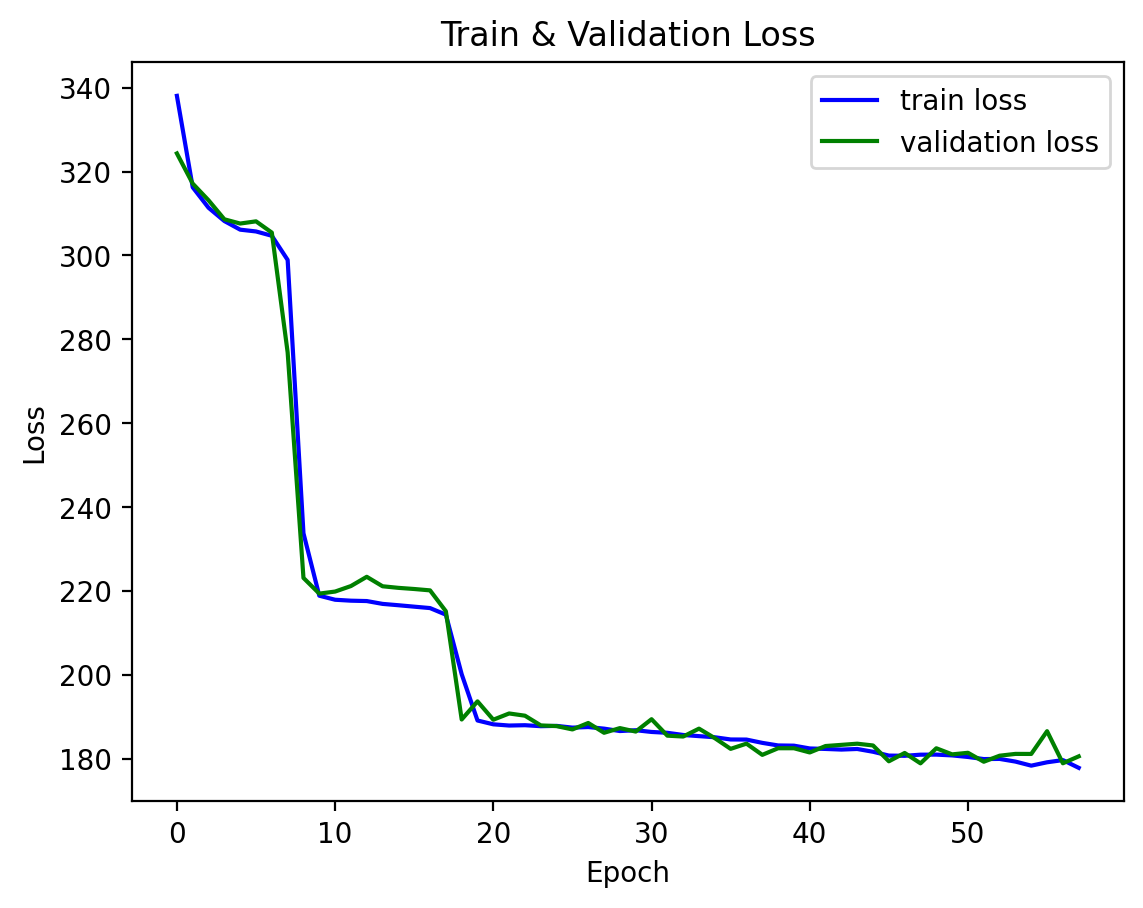

In [61]:
### Plot the Train & Validation Loss after the training: 

plt.figure()
plt.plot(train_loss,'b',label = "train loss")
plt.plot(val_loss,'g', label = "validation loss")
plt.title('Train & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('plot.png')  # save the plot

## To load a trained model: 

In [ ]:
# Choose a model: 

PATH = "state_dict_cVAE_Beta=0.1.pt"
#PATH = "state_dict_cVAE_Beta=1.pt"
#PATH = "state_dict_cVAE_Beta=2.pt"


VAE = Cond_Variational_Autoencoder(latent_dims).to(device)
VAE.load_state_dict(torch.load(PATH))
VAE.eval()

# Visualise the differences between the inputs and the ouputs generated:


In [62]:
with torch.no_grad():
    for x, y in test_dataloader: # batch of size 50
        x = x.to(device)
        y = y.to(device)
        x_out = cVAE(x.float(), y.float())
        break

In [63]:
x_array = x[1:5].detach().cpu().numpy()  # The inputs
x_out_array = x_out[1:5].detach().cpu().numpy() # The outputs 

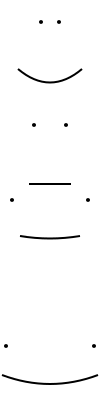

In [64]:
# The inputs: 
draw_column(x_array)

In [65]:
# To save the drawing uncomment the lines below: 

#d = draw_column(x_array)
#d.saveSvg("CVAE_inputs.svg")

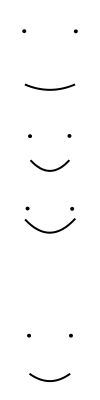

In [66]:
# The outputs: 
draw_column(x_out_array)

In [67]:
# To save the drawing uncomment the lines below: 

#d = draw_column(x_out_array)
#d.saveSvg("CVAE_outputs.svg")

# We can check the distribution in the latent space by passing data only through the encoder:

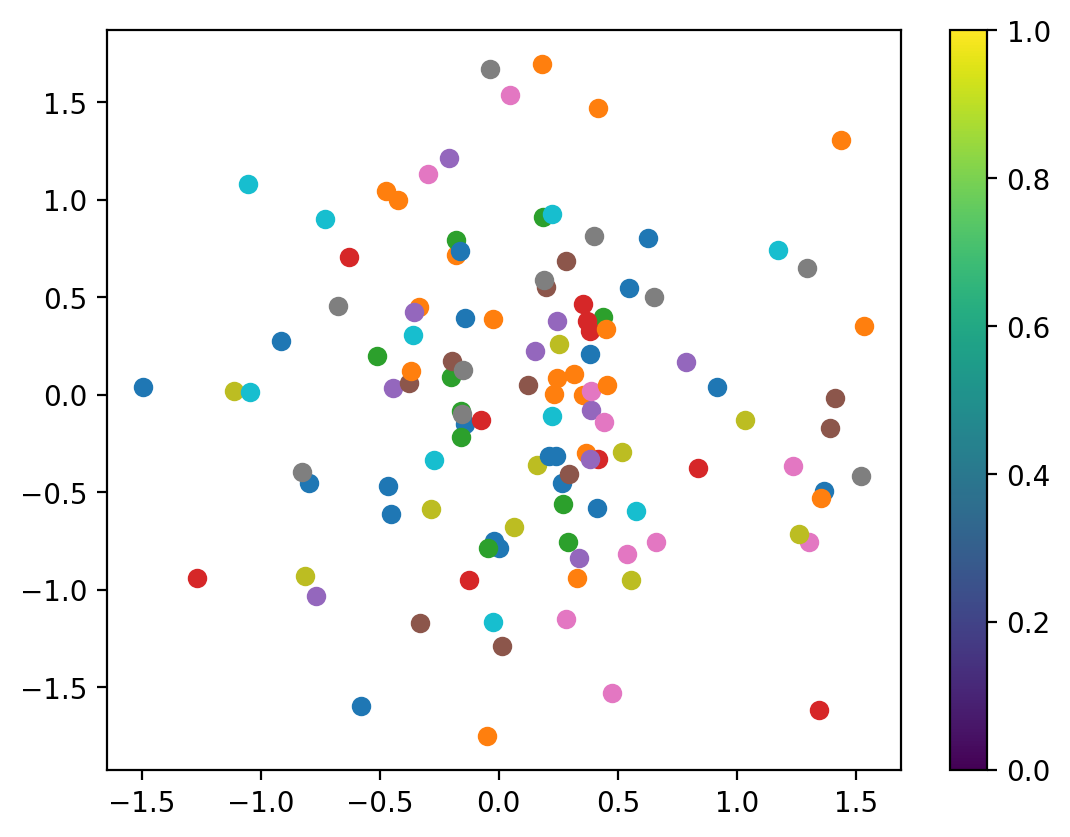

In [68]:
plot_latent_cond(cVAE, train_dataloader) 

- One cane see that we have a normal distribution N(0,1)

# Generate a grid of smileys:

In [69]:
# Generate smiley from noisy vectors following a Gaussian distribution N(0,1)

with torch.no_grad():
    noise = torch.randn(100, 2).to(device) # Choose a sample of 100 latent vectors
    y = np.zeros(100)
    for i in range(0, 100):
        y[i] = randint(0, 1)  # the label 
    y = torch.from_numpy(y).to(device) # convert into a tensor 
    x_out = cVAE.decoder(noise.float(), y.float())
    x_out = x_out.detach().numpy()

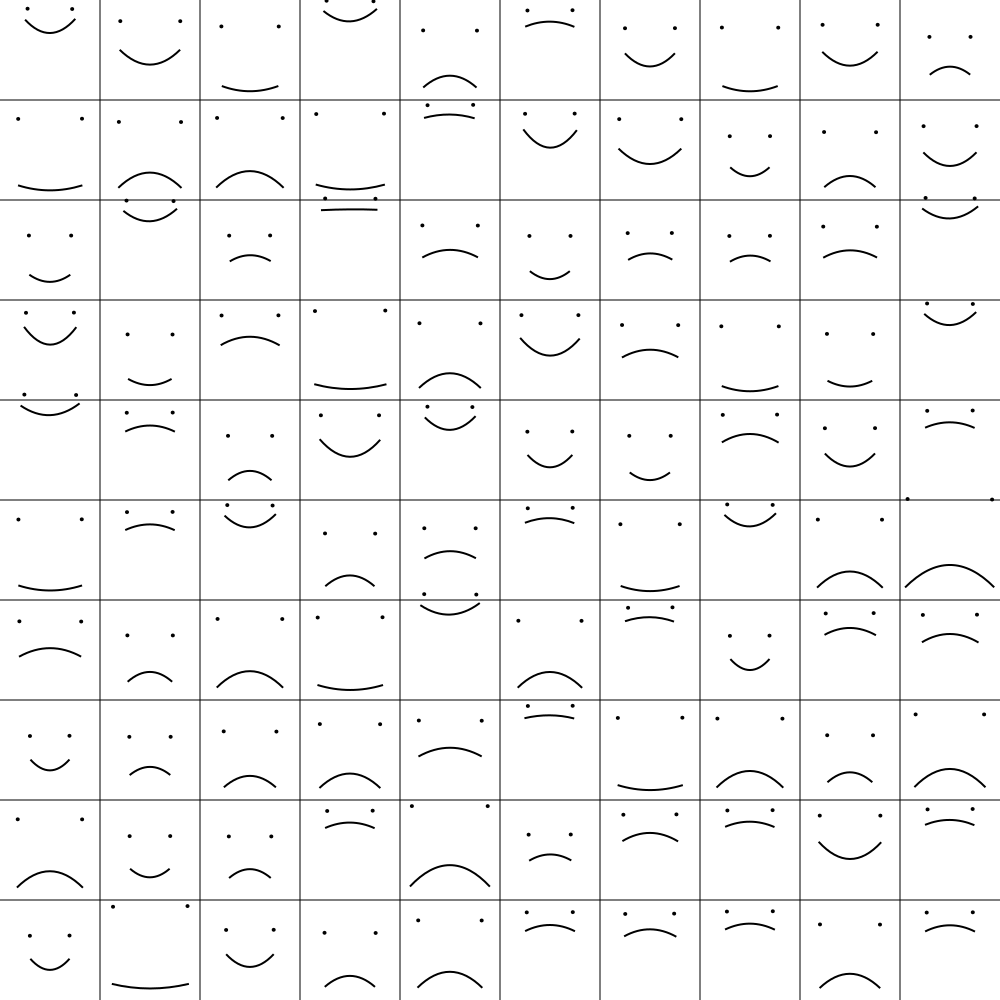

In [70]:
draw_grid(x_out)

In [71]:
# To save the drawing uncomment the lines below: 

#d = draw_grid(x_out)
#d.saveSvg("CVAE_rand_grid.svg")

In [72]:
# Generate smileys from vectors z = (z1, z2) with a regular sampling over z1 and z2 (values between -0.9 and 0.9)

# First we consider y = 1 

with torch.no_grad():
    noise = np.zeros((100, 2)) # Choose a sample of 100 latent vectors
    for i in range(10):
        for j in range(10):
            noise[j + i * 10, 0] = -0.9 + j * 0.2
            noise[j + i * 10, 1] = -0.9 + i * 0.2
    #print(noise)
    noise = torch.tensor(noise)
    y = torch.ones(100)
    
    
    x_out = cVAE.decoder(noise.float(),y.float())
    x_out = x_out.detach().numpy()

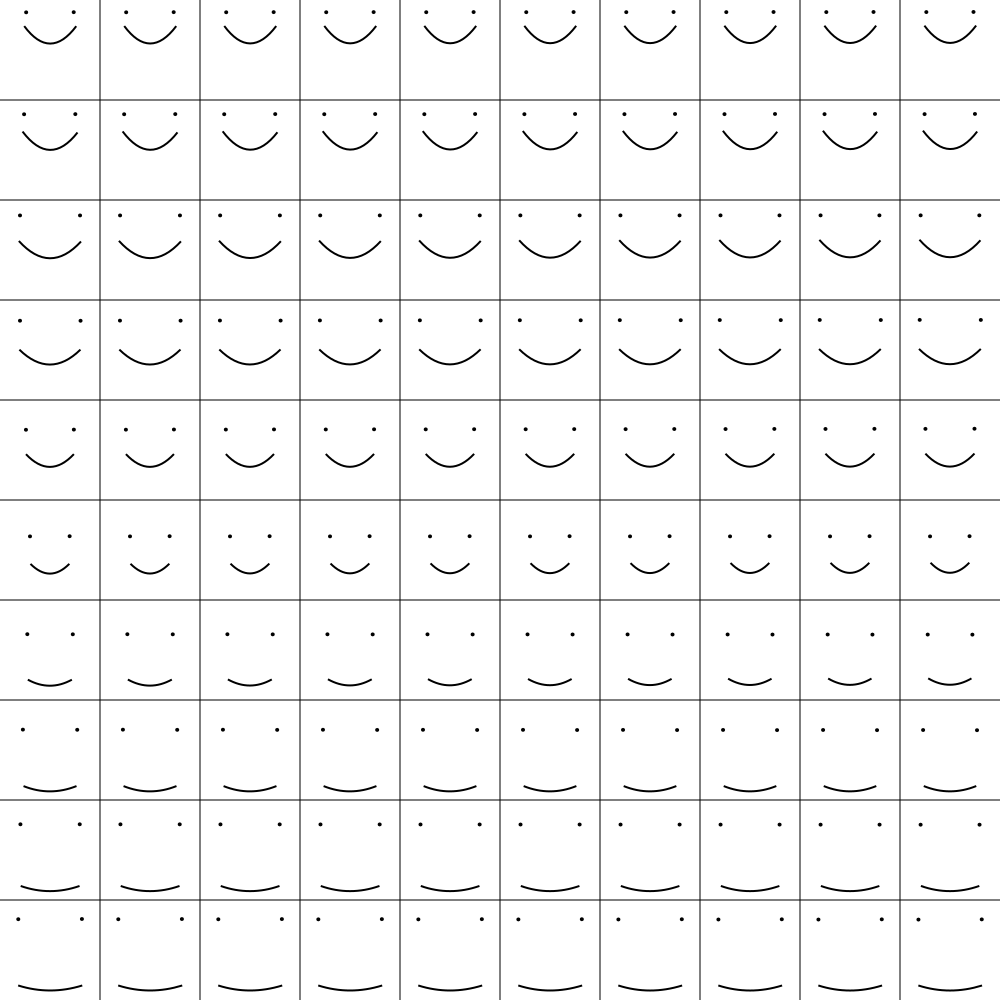

In [73]:
draw_grid(x_out)

In [74]:
# To save the drawing uncomment the lines below: 

#d = draw_grid(x_out)
#d.saveSvg("CVAE_grid_y=1.svg")

In [75]:
# Same thing with y = 0 

with torch.no_grad():
    noise = np.zeros((100, 2)) # Choose a sample of 100 latent vectors
    for i in range(10):
        for j in range(10):
            noise[j + i * 10, 0] = -0.9 + j * 0.2
            noise[j + i * 10, 1] = -0.9 + i * 0.2
    #print(noise)
    noise = torch.tensor(noise)
    y = torch.zeros(100) 
    x_out = cVAE.decoder(noise.float(),y.float())
    x_out = x_out.detach().numpy()

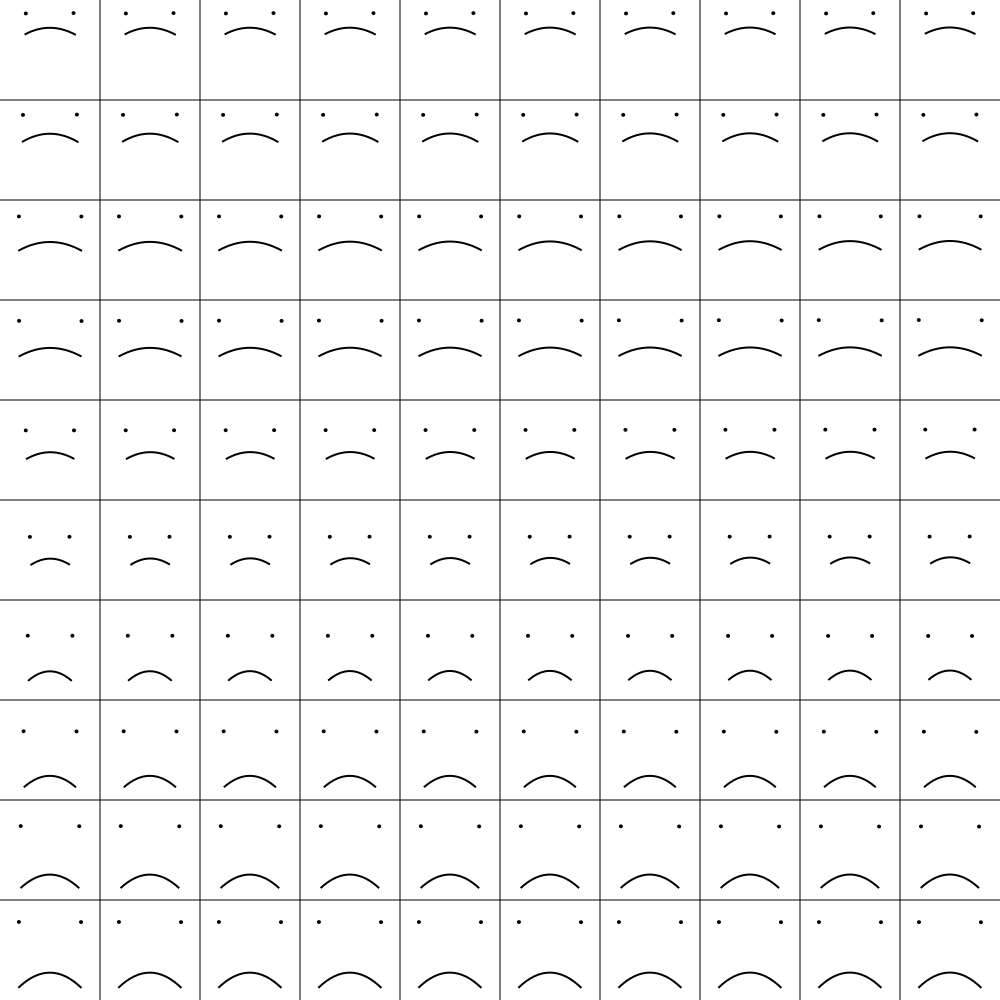

In [76]:
draw_grid(x_out)

In [58]:
# To save the drawing uncomment the lines below: 

#d = draw_grid(x_out)
#d.saveSvg("CVAE_grid_y=0.svg")

# Generate a smiley from a vector z = (z1, z2): 

In [26]:
# Choice of z: 
z1 = 0.0
z2 = -0.5

# Choice of y: 
y = 0

In [27]:
z = np.array([[z1, z2]])
z = torch.tensor(z)

y = np.array([y])
y = torch.tensor(y)

x_out = cVAE.decoder(z.float(),y.float())
x_out = x_out.detach().numpy()
x_out = x_out[0]

draw_smiley(x_out)

## To save a model: 

In [77]:
# Specify a path
PATH = "state_dict_cVAE_Beta=2.pt"

# Save
torch.save(cVAE.state_dict(), PATH)